In [1]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
#from causallearn.search.ConstraintBased.PC import pc

#import functions

In [69]:
low_scatter_para=['ETG','T-type','Bar', 'Disk', 'Ring', 'Core', 'Multiple', 'Compactness', 'AGN',
       'Pseudobulge', 'BCG', 'cD','M*_sph', 'M*_gal', 'log_B/T',
       'log_sigma0', 'log_R_e_sph_maj','log_R_e_sph_eq_kpc', 'log_n_sph_maj', 'log_n_sph_eq', 'log(I_e,sph,maj/M_Sun/pc^2)',
       'log(I_e,sph,eq/M_Sun/pc^2)', 'Concentration_Index',
       'avg_Rho_1kpc_Exact_All', 'r1_density_approx', 'log10(R10_kpc)',
       'logRho_R10_approx', 'log_rho10_Exact', 'log10(R90_kpc)',
       'logRho_R90_approx', 'log_rho_90_Exact_all', 'Rho_re_spatial',
       'SR_pc_All', 'Rho_SR_pc_All', 'CR_def1_approx_new',
       'Rho_cr_def1_approx_new', 'CR_def2_approx_new',
       'Rho_CR_def2_approx_new', 'Sr(pc)_2_using_Falserm_drho',
       'Log_Approx_Avg_density_10pc', 'log_Rho_e_Exact_new',
       'logRho_e_approx_New', 'logRho_soi_approx_new',
       'log_Rho_soi_exact_new', 'Avg_Rho_Re_Exact_all',
       'Avg_Rho_soi_exact_all', 'Avg_Rho_re_Exact_all', 'Rho_re_Exact_all',
       'Rho_r_soi_2BH_approx', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_Rho_10kpc_exact_final', 'Log_Avg_Rho_100pc_approx',
       'Log_Avg_Rho_5kpc_approx', 'Log_Avg_rho_5kpc_exact_all', 'ube', 'bve',
       'dc', 'bvtc', 'bri25', 'mabs', 'blum', 'logblum', 'logSigma0sph',
       'LogSigma0', 'R10', 'logR10', 'logR10phi', 'Rh', 'logRh', 'logRhphi',
       'logHalo','M_BH']

In [3]:
df_full = pd.read_csv('../SMBH_Data_0911.csv',header=1)


paras=low_scatter_para.copy()
if paras[-1]!='M_BH':
    paras.append('M_BH')
paras.append('M_BH_std')

obs=df_full.copy()
obs = obs[paras].dropna(axis='index',how='any')
print(len(obs))

y = obs['M_BH'].to_numpy()
w = 1/obs['M_BH_std'].to_numpy()**2

X = obs.iloc[:,:-2].to_numpy()

100


In [89]:
# start over 100 times, each time evolve 300 generations
#evolutions = 1
#niterations = 10
evolutions = 50
niterations = 500


denoise=False
ncyclesperiteration=2000
adaptive_parsimony_scaling=20
verbosity=0
return_model=True
maxsize=25
optimizer_algorithm="NelderMead"
optimizer_iterations=100
optimizer_nrestarts=5
should_simplify=True
temp_equation_file=True  # turn this on will prevent the auto-save of hall_of_fame
tempdir='/data/zj448/SR/Ultimate_paper/temp/'  # dummy dir to save temp files and then being auto deleted

In [81]:
for epoch in tqdm(range(evolutions),desc='evolution'):

    warm_start=True
    model = PySRRegressor(
        binary_operators=["+", "-", "*", "/","pow"],
        unary_operators=["exp","log10"],
        constraints={"pow": (9, 1)}, # power laws can have 9 complexity left argument, but only 1 complexity in the right argument.
        warm_start=warm_start,
        denoise=denoise,
        niterations=1,
        ncyclesperiteration=ncyclesperiteration,
        adaptive_parsimony_scaling=adaptive_parsimony_scaling,
        verbosity=verbosity,
        precision=64,
        maxsize=maxsize,
        optimizer_algorithm=optimizer_algorithm,
        optimizer_iterations=optimizer_iterations,
        optimizer_nrestarts=optimizer_nrestarts,
        should_simplify=should_simplify,
        temp_equation_file=temp_equation_file,
        tempdir=tempdir,
        )
    
    for iter in range(niterations):
        

        model.fit(X=X, y=y, weights=w)


        equations = model.equations_
    
        number_matching_pattern = r"(?<![a-zA-Z0-9_.])[+-]?(\d+\.\d+|\.\d+|\d+\.|\d+)(?:[eE][-+]?\d+)?"

        variable_matching_pattern = r'\bx\d+'


        # Count number of constants:
        equations["number_constants"] = [len(re.findall(number_matching_pattern, eq)) for eq in equations["equation"]]

        # count number of (unique) variables
        equations["variables"]=[set(re.findall(variable_matching_pattern, eq)) for eq in equations["equation"]]
        equations["number_variables"] = [len(re.findall(variable_matching_pattern, eq)) for eq in equations["equation"]]
        equations["unique_number_variables"] = [len(set(re.findall(variable_matching_pattern, eq))) for eq in equations["equation"]]
        

        # Compute log likelihood (for example)
        equations["log_like"] = - equations["loss"] * len(X)

        # Compute AIC:
        equations["aic"] = 2 * equations["number_constants"] - 2 * equations["log_like"]

        equations['evolutions']=epoch
        equations['iterations']=iter

        if epoch==0 and iter==0:
            equations.to_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto_500_100.csv',index=False)
        else:
            equations.to_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto_500_100.csv',index=False,mode='a',header=False)

        #warm_start=False

evolution:   0%|          | 0/1 [00:00<?, ?it/s]/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1937: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. You should run PySR for more `niterations` to ensure it can find the correct variables, or, alternatively, do a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(
/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be 

In [14]:
equations

,complexity,loss,score,equation,sympy_format,lambda_format,number_constants,variables,number_variables,unique_number_variables,log_like,aic,evolutions,iterations
0,1,1.264167,0.000000,7.5711296458231025,7.5711296458231025,PySRFunction(X=>7.5711296458231025),1,{},0,0,-126.416737,254.833473,2,2
1,3,0.338253,0.659187,(x17 + 7.90565783341977),x17 + 7.90565783341977,PySRFunction(X=>x17 + 7.90565783341977),1,{x17},1,1,-33.825303,69.650606,2,2
2,4,0.280564,0.186993,(x69 - exp(x3)),x69 - exp(x3),PySRFunction(X=>x69 - exp(x3)),0,"{x69, x3}",2,2,-28.056389,56.112778,2,2
3,5,0.172566,0.486023,((x15 ^ 1.8769317581523237) + 3.61180801355849),x15**1.8769317581523237 + 3.61180801355849,PySRFunction(X=>x15**1.8769317581523237 + 3.61...,2,{x15},1,1,-17.256575,38.513149,2,2
4,7,0.169701,0.008370,(((x69 / 1.2782770440195763) + x16) + -0.31150...,x16 + 0.78230302631069185*x69 - 0.311503020285...,PySRFunction(X=>x16 + 0.78230302631069185*x69 ...,2,"{x16, x69}",2,2,-16.970116,37.940232,2,2
5,8,0.142545,0.174383,((x69 - exp(1.0451524346431438 ^ x30)) + x17),x17 + x69 - exp(1.0451524346431438**x30),PySRFunction(X=>x17 + x69 - exp(1.045152434643...,1,"{x30, x17, x69}",3,3,-14.254474,30.508948,2,2
6,9,0.131932,0.077369,(((x69 / 1.2073895716480354) + (x14 + -0.38676...,x14 + x16 + 0.82823309351185015*x69 - 0.386763...,PySRFunction(X=>x14 + x16 + 0.8282330935118501...,2,"{x16, x69, x14}",3,3,-13.193209,30.386418,2,2
7,11,0.117259,0.058949,(((x15 ^ 1.8769317581523237) + 3.6118080135584...,x15**1.8769317581523237 + 3.61180801355849 + (...,PySRFunction(X=>x15**1.8769317581523237 + 3.61...,3,"{x28, x15, x39}",3,3,-11.725937,29.451875,2,2
8,14,0.047996,0.297760,(((log10((x33 / x48) / (0.048284879330549695 ^...,x26 - x29 + x57 + log(x33/(0.04828487933054969...,PySRFunction(X=>x26 - x29 + x57 + log(x33/(0.0...,1,"{x21, x26, x33, x29, x57, x48}",6,6,-4.799554,11.599108,2,2
9,16,0.045367,0.028161,(((log10((x33 / x48) / (0.048284879330549695 ^...,x26 - x29 + log(x33/(0.048284879330549695**x21...,PySRFunction(X=>x26 - x29 + log(x33/(0.0482848...,3,"{x21, x26, x33, x29, x48}",5,5,-4.536701,15.073401,2,2


In [66]:
t=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto.csv')

In [43]:
t

,complexity,loss,score,equation,sympy_format,lambda_format,number_constants,variables,number_variables,unique_number_variables,log_like,aic,evolutions,iterations
0,1,0.824938,0.000000e+00,8.233873226498982,8.233873226498982,PySRFunction(X=>8.233873226498982),1,set(),0,0,-82.493831,166.987662,0,0
1,3,0.209660,6.849115e-01,(x12 / 1.282624366420539),0.7796514912551771*x12,PySRFunction(X=>0.7796514912551771*x12),1,{'x12'},1,1,-20.965965,43.931931,0,0
2,5,0.203388,1.518516e-02,((x12 / 1.2782770440195763) + x11),x11 + 0.78230302631069185*x12,PySRFunction(X=>x11 + 0.78230302631069185*x12),1,"{'x11', 'x12'}",2,2,-20.338794,42.677589,0,0
3,6,0.184684,9.646663e-02,((x12 / 1.282624366420539) + log10(x57)),0.7796514912551771*x12 + log(x57)/log(10),PySRFunction(X=>0.7796514912551771*x12 + log(x...,1,"{'x57', 'x12'}",2,2,-18.468443,38.936886,0,0
4,7,0.177063,4.214051e-02,((x12 / 1.2782770440195763) + (x11 + -0.090289...,x11 + 0.78230302631069185*x12 - 0.090289723296...,PySRFunction(X=>x11 + 0.78230302631069185*x12 ...,2,"{'x11', 'x12'}",2,2,-17.706344,39.412688,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,12,0.117866,1.799829e-02,((exp(x68 / 5.640540296137331) + ((x15 * 4.048...,4.048178040101782*x15 + x19 + exp(0.1772879808...,PySRFunction(X=>4.048178040101782*x15 + x19 + ...,3,"{'x19', 'x68', 'x15'}",3,3,-11.786569,29.573138,0,29
348,15,0.111226,1.932727e-02,(((x51 + 0.358213204852026) + (x25 - (x43 / ((...,x25 - x43/(8.0222540373856835 - x43) + x51 + 7...,PySRFunction(X=>x25 - x43/(8.0222540373856835 ...,4,"{'x25', 'x51', 'x43'}",4,3,-11.122597,30.245195,0,29
349,16,0.074904,3.953602e-01,(log10(exp((exp(exp(x49) + 1.8717260823451458)...,log(exp(-x42)*exp(x12 + x54 + 6.49950540420136...,PySRFunction(X=>log(exp(-x42)*exp(x12 + x54 + ...,2,"{'x42', 'x49', 'x12', 'x54'}",4,4,-7.490373,18.980746,0,29
350,18,0.074904,3.520914e-07,(log10((exp((exp(exp(x49) + 1.8717260823451458...,log((-x56 + exp(x12 + x54 + 6.499505404201366*...,PySRFunction(X=>log((-x56 + exp(x12 + x54 + 6....,2,"{'x56', 'x12', 'x42', 'x54', 'x49'}",5,5,-7.490368,18.980736,0,29


In [35]:
#show evolution=1 and iteration=1
t[(t['evolutions']==1) & (t['iterations']==1)]

,complexity,loss,score,equation,sympy_format,lambda_format,number_constants,variables,number_variables,unique_number_variables,log_like,aic,evolutions,iterations
50,1,0.824938,0.000000,8.233873226498694,8.233873226498694,PySRFunction(X=>8.233873226498694),1,set(),0,0,-82.493831,166.987662,1,1
51,3,0.211508,0.680522,(x12 / 1.2782770440195763),0.78230302631069185*x12,PySRFunction(X=>0.78230302631069185*x12),1,{'x12'},1,1,-21.150850,44.301699,1,1
52,5,0.183890,0.069964,((x12 + x11) / 1.2782770440195763),0.78230302631069185*x11 + 0.78230302631069185*x12,PySRFunction(X=>0.78230302631069185*x11 + 0.78...,1,"{'x11', 'x12'}",2,2,-18.388980,38.777961,1,1
53,7,0.163053,0.060131,(((x12 + -0.11050637080399661) + x11) / 1.2782...,0.78230302631069185*x11 + 0.78230302631069185*...,PySRFunction(X=>0.78230302631069185*x11 + 0.78...,2,"{'x11', 'x12'}",2,2,-16.305301,36.610601,1,1
54,8,0.142545,0.134419,((x69 - exp(1.0451524346431438 ^ x30)) + x17),x17 + x69 - exp(1.0451524346431438**x30),PySRFunction(X=>x17 + x69 - exp(1.045152434643...,1,"{'x30', 'x17', 'x69'}",3,3,-14.254474,30.508948,1,1
55,11,0.109147,0.088988,(x69 + ((x16 - ((x42 + 2.105379690610612) * 0....,x16 - 0.2895777248120232*x42 + x69 - 1.7891595...,PySRFunction(X=>x16 - 0.2895777248120232*x42 +...,3,"{'x16', 'x42', 'x69'}",3,3,-10.914654,27.829307,1,1
56,14,0.101769,0.023329,(((x12 / (1.2782770440195763 - -0.194083590801...,0.67918142902629807*x12 + exp(x18)/x43**0.5584...,PySRFunction(X=>0.67918142902629807*x12 + exp(...,4,"{'x43', 'x18', 'x12'}",3,3,-10.176884,28.353769,1,1
57,17,0.101564,0.000672,(x69 + ((x16 - ((x42 + x2) ^ 0.273273384313199...,x16 + x69 - (x2 + x42)**0.27327338431319914 - ...,PySRFunction(X=>x16 + x69 - (x2 + x42)**0.2732...,4,"{'x16', 'x42', 'x69', 'x2'}",5,4,-10.156383,28.312766,1,1
58,18,0.083892,0.191157,((((x12 + ((x48 ^ 0.6439466001295374) / x48)) ...,0.80082789517033368*x12 + 0.80082789517033368/...,PySRFunction(X=>0.80082789517033368*x12 + 0.80...,4,"{'x18', 'x48', 'x23', 'x12'}",5,4,-8.389199,24.778398,1,1
59,19,0.081052,0.034442,((((x12 + ((x48 ^ 0.6439466001295374) / x48)) ...,0.80082789517033368*x12 + 0.80082789517033368/...,PySRFunction(X=>0.80082789517033368*x12 + 0.80...,5,"{'x18', 'x48', 'x23', 'x12'}",5,4,-8.105175,26.210349,1,1


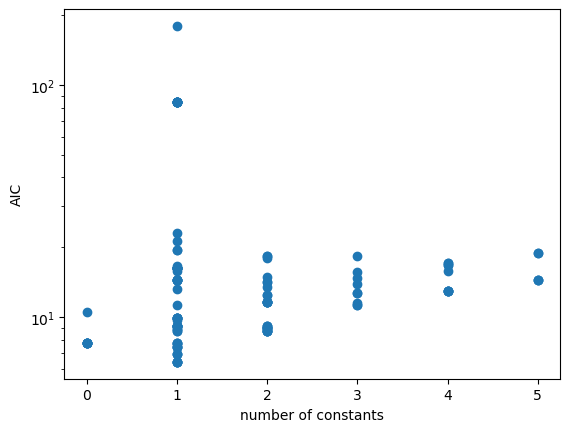

In [99]:
t=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto_5000.csv')

plt.scatter(t['number_constants'],2 * t["number_constants"] -  t["log_like"])
plt.xlabel('number of constants')
plt.ylabel('AIC')
plt.yscale('log')

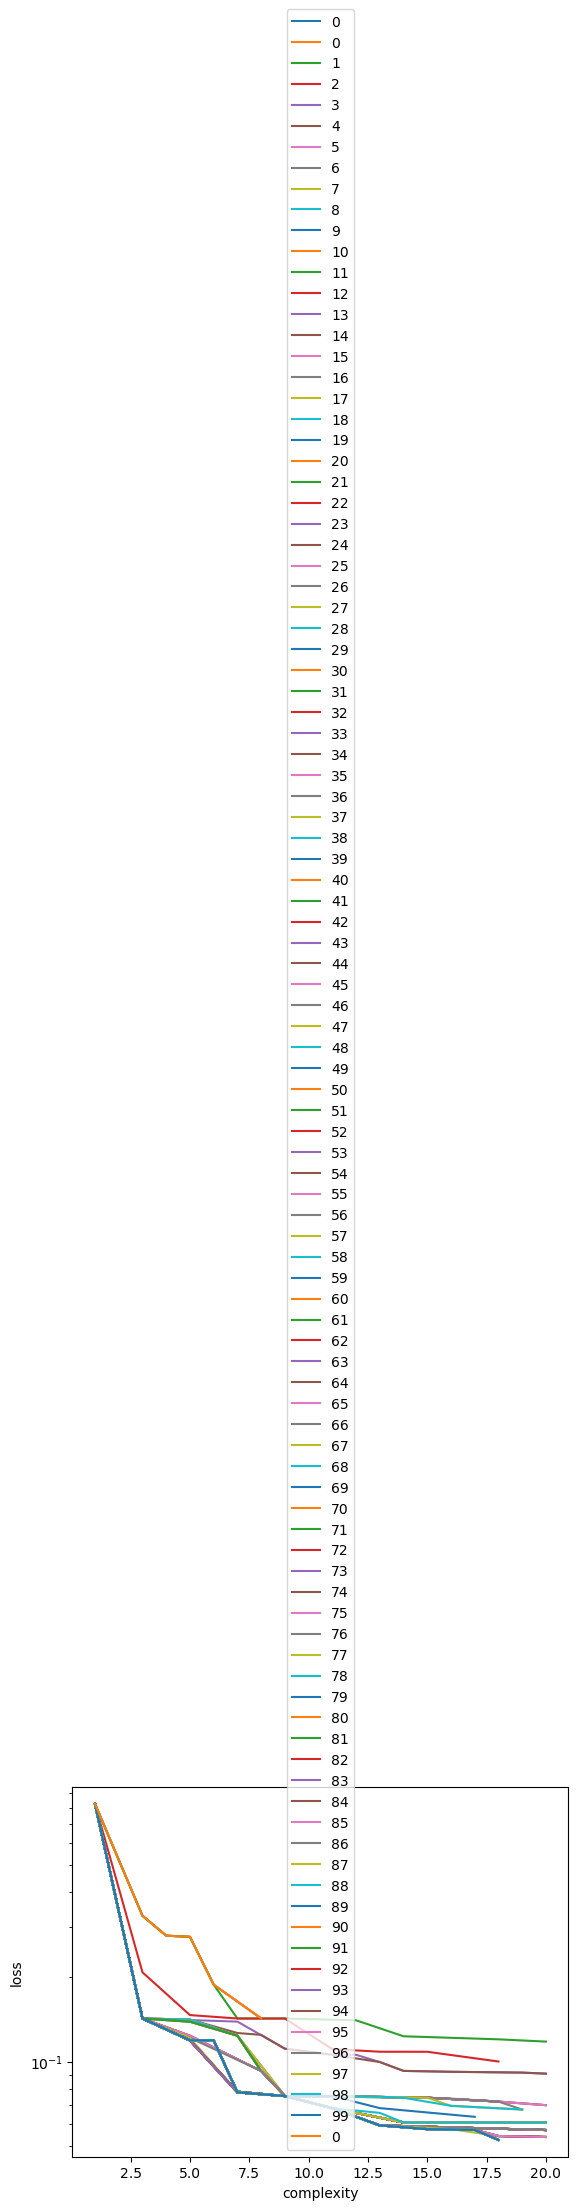

In [82]:
t=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto_500_100.csv')

fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')

def animate(i):
    t_i=t[t['iterations']==i]
    ax.plot(t_i['complexity'],t_i['loss'],label=i)
    ax.legend()
    return ax

anim = FuncAnimation(fig, animate, frames=np.arange(0, niterations), interval=1000)
HTML(anim.to_html5_video())


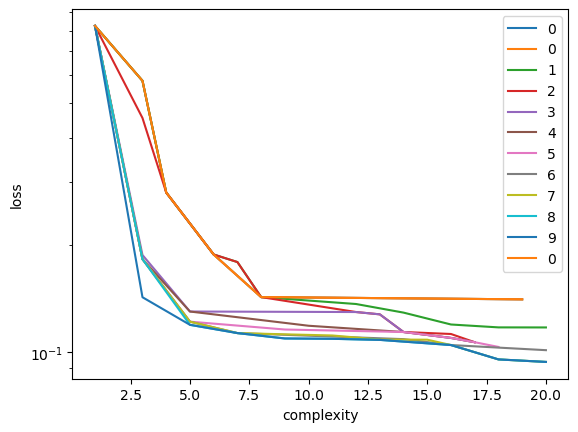

In [76]:
t=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto_500.csv')

fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')

def animate(i):
    t_i=t[t['iterations']==i]
    ax.plot(t_i['complexity'],t_i['loss'],label=i)
    ax.legend()
    return ax

anim = FuncAnimation(fig, animate, frames=np.arange(0, niterations), interval=1000)
HTML(anim.to_html5_video())


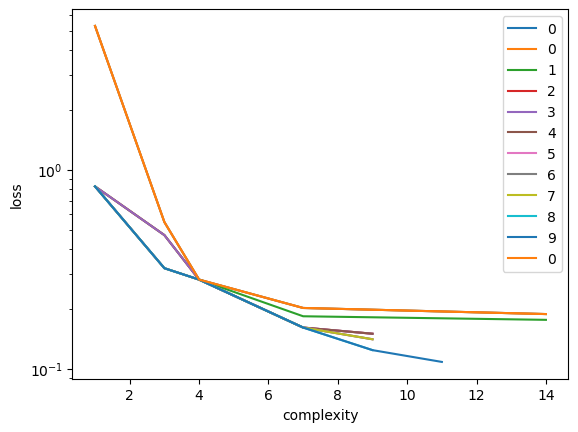

In [79]:
t=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto_50.csv')

fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')

def animate(i):
    t_i=t[t['iterations']==i]
    ax.plot(t_i['complexity'],t_i['loss'],label=i)
    ax.legend()
    return ax

anim = FuncAnimation(fig, animate, frames=np.arange(0, niterations), interval=1000)
HTML(anim.to_html5_video())

In [48]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

t=pd.read_csv('/data/zj448/SR/Ultimate_paper/pareto_archive/pareto.csv')

evolution=1

t=t[t['evolutions']==evolution]
niterations=t['iterations'].max()+1
#niterations=10


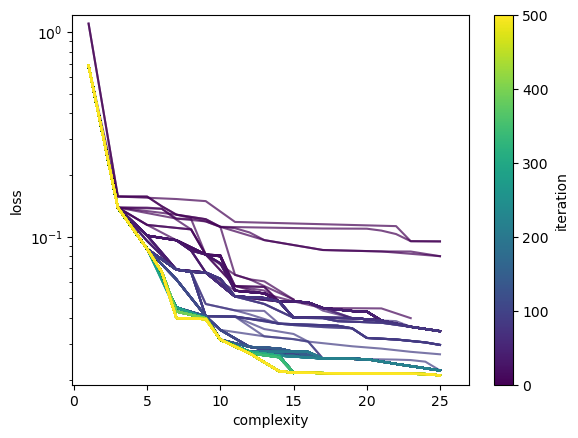

In [3]:
# plot the pareto front for each iteration
fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_xlim(-0.1,27)
ax.set_ylim(t['loss'].min()*0.9,t['loss'].max()*1.1)

colors = plt.cm.viridis(np.linspace(0,1,niterations))

for i in range(niterations):
    t_i=t[t['iterations']==i]
    ax.plot(t_i['complexity'],t_i['loss'],color=colors[i],alpha=0.7)

plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=niterations), cmap='viridis'), ax=ax, label='iteration')

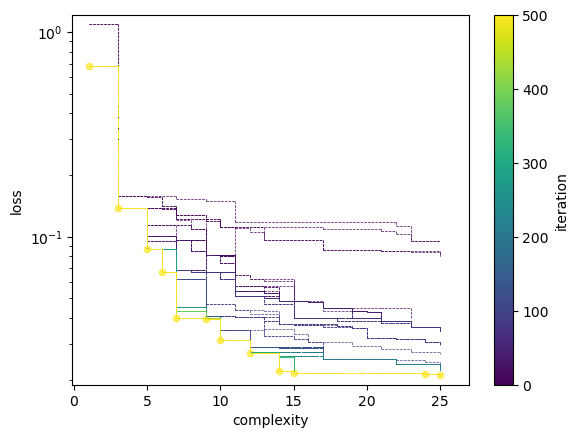

In [51]:
# plot the pareto front for each iteration
fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_xlim(-0.1,27)
ax.set_ylim(t['loss'].min()*0.9,t['loss'].max()*1.1)

colors = plt.cm.viridis(np.linspace(0,1,niterations))

for i in range(niterations):
    t_i=t[t['iterations']==i]
    for j in range(len(t_i) - 1):
        ax.plot([t_i['complexity'].iloc[j], t_i['complexity'].iloc[j+1]], [t_i['loss'].iloc[j], t_i['loss'].iloc[j]],ls='--', linewidth=0.5,color=colors[i])
        ax.plot([t_i['complexity'].iloc[j+1], t_i['complexity'].iloc[j+1]], [t_i['loss'].iloc[j], t_i['loss'].iloc[j+1]], ls='--', linewidth=0.5,color=colors[i])
    if i==niterations-1:
        ax.scatter(t_i['complexity'],t_i['loss'],color=colors[i],alpha=0.7,s=20)

plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=niterations), cmap='viridis'), ax=ax, label='iteration')

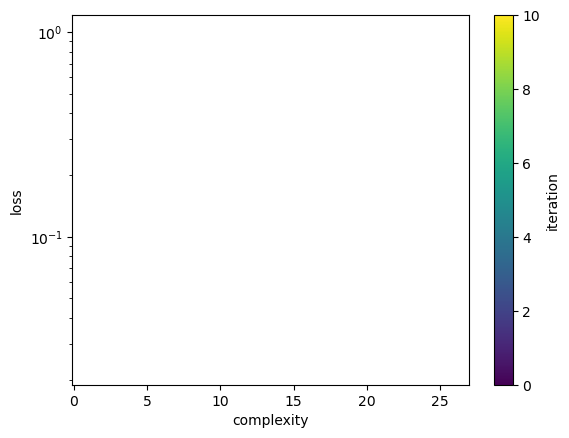

In [44]:
# animate the pareto front as iterations evolve.
fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_xlim(-0.1,27)
ax.set_ylim(t['loss'].min()*0.9,t['loss'].max()*1.1)
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=niterations), cmap='viridis'), ax=ax, label='iteration')

colors = plt.cm.viridis(np.linspace(0,1,niterations))

def animate(i):
    t_i=t[t['iterations']==i]
    if i>0:
        t_ii=t[t['iterations']==i-1]
        # remove previous iteration
        ax.lines[-1].remove()
        ax.plot(t_ii['complexity'],t_ii['loss'],color=colors[i-1],alpha=0.7,ls='--')
    # plot current iteration
    ax.plot(t_i['complexity'],t_i['loss'],color=colors[i],alpha=0.7)
        
    return ax

def init():
    
    return ax


#anim = FuncAnimation(fig, animate,init_func=init , frames=np.arange(0, niterations), interval=20)
anim = FuncAnimation(fig, animate,init_func=init , frames=np.arange(0, niterations), interval=1000)
#HTML(anim.to_html5_video())

In [45]:
HTML(anim.to_html5_video())

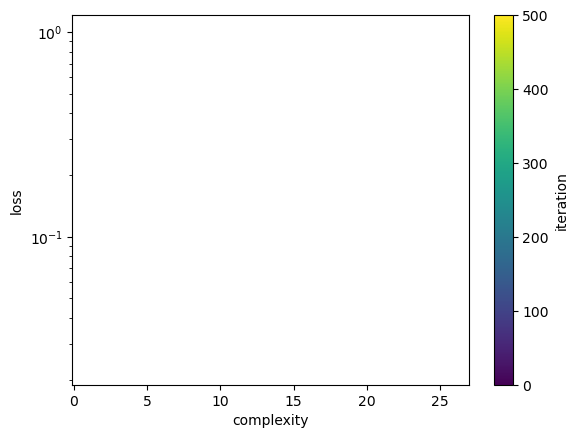

In [52]:
# animate the pareto front as iterations evolve.
fig, ax = plt.subplots()
ax.set_xlabel('complexity')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_xlim(-0.1,27)
ax.set_ylim(t['loss'].min()*0.9,t['loss'].max()*1.1)
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=niterations), cmap='viridis'), ax=ax, label='iteration')

colors = plt.cm.viridis(np.linspace(0,1,niterations))

def animate(i):
    t_i=t[t['iterations']==i]
    # if i>0:
    #     t_ii=t[t['iterations']==i-1]
    #     # remove previous iteration
    #     ax.lines[-1].remove()
    #     ax.plot(t_ii['complexity'],t_ii['loss'],color=colors[i-1],alpha=0.7,ls='--')
    # # plot current iteration
    # ax.plot(t_i['complexity'],t_i['loss'],color=colors[i],alpha=0.7)

    if i>0:
        #remove the previous scatter points
        ax.collections[-1].remove()

    ax.scatter(t_i['complexity'],t_i['loss'],color=colors[i],alpha=0.7,s=20)
    # connect the points with stairs
    for j in range(len(t_i) - 1):
        ax.plot([t_i['complexity'].iloc[j], t_i['complexity'].iloc[j+1]], [t_i['loss'].iloc[j], t_i['loss'].iloc[j]],ls='--', linewidth=0.5,color=colors[i])
        ax.plot([t_i['complexity'].iloc[j+1], t_i['complexity'].iloc[j+1]], [t_i['loss'].iloc[j], t_i['loss'].iloc[j+1]], ls='--', linewidth=0.5,color=colors[i])
        
    return ax

def init():
    
    return ax


anim = FuncAnimation(fig, animate,init_func=init , frames=np.arange(0, niterations), interval=20)
#anim = FuncAnimation(fig, animate,init_func=init , frames=np.arange(0, niterations), interval=1000)
#HTML(anim.to_html5_video())

In [53]:
HTML(anim.to_html5_video())

In [62]:
anim.save('/home/zj448/Ultimate_black_hole_mass_scaling_relations_Symbolic_Regression/Blackhole_properties/Ultimate_paper/evolution1.mp4', fps=50, codec='h264')

<Figure size 640x480 with 0 Axes>